# Assignment 3

In [1]:
import os
import glob

import pickle

import numpy as np
import pandas as pd

import cv2
from sklearn import svm

import matplotlib.pyplot as plt 

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans

from PIL import Image

In [2]:
print(cv2.__version__)

4.5.3


# get bags of SIFT

In [3]:


def get_bags_of_sifts(image_paths):
    #load Dictionary
    vocab = np.load('vocab.pkl',allow_pickle=True)
    size_of_vocab = vocab.shape[0]
    
    
    images = []
    image_feats = []
    for imgpath in image_paths:
        im = Image.open(imgpath)
        im.thumbnail((200,200))
        images.append(np.array(im))

    sift = cv2.xfeatures2d.SIFT_create(60)
    
    
    #We compare every feature in the image with our dictionary word.
    #The word with which the feature has least diff, we increment that word in our img histogram
    
    
    for img in images:
        
        img_hist = np.zeros((size_of_vocab))
        kp, des = sift.detectAndCompute(img,None)
        for feature in des:
            min_dist = 1000
            min_idx = -1
            for i in range(len(vocab)):
                diff = vocab[i]-feature
                diff = np.dot(diff.T, diff)
                diff = np.sqrt(diff)
                
                if(diff < min_dist):
                    min_dist = diff
                    min_idx = i
            
            img_hist[min_idx] +=1
            
        img_hist = (img_hist-np.min(img_hist))/(np.max(img_hist)-np.min(img_hist))
        image_feats.append(img_hist)
        
    
    image_feats = np.array(image_feats)
    

    
    return image_feats

# image_paths is an N x 1 cell array of strings where each string is an
# image path on the file system.

# This function assumes that 'vocab.pkl' exists and contains an N x 128
# matrix 'vocab' where each row is a kmeans centroid or visual word. This
# matrix is saved to disk rather than passed in a parameter to avoid
# recomputing the vocabulary in every run.

# image_feats is an N x d matrix, where d is the dimensionality of the
# feature representation. In this case, d will equal the number of clusters
# or equivalently the number of entries in each image's histogram
# ('vocab_size') below.



#  SIFT_features is a 128 x N matrix of SIFT features






# Build Vocabulary 

In [4]:

#This function will sample SIFT descriptors from the training images,
#cluster them with kmeans, and then return the cluster centers.

def build_vocabulary(image_paths, vocab_size):
    images=[]
    
    for imgpath in image_paths:
        images.append(cv2.imread(imgpath,0))
        
        
        
        
        
    sift_features = []
    images = np.array(images)
    sift = cv2.xfeatures2d.SIFT_create()
    
    #computing SIFT to get descriptors from each image
    for img in images:
        kp, des = sift.detectAndCompute(img,None)
        for x in des:
            sift_features.append(x.tolist())
        
   
    sift_features = np.array(sift_features)
    print("Shape of Sift features that are feeded to kMeans: ",sift_features.shape)
    print("Computing kMeans...")
    #running Kmeans to get visual words
    print("Size of vocab ",vocab_size)
    kmeans = KMeans(n_clusters = vocab_size, n_init=10)
    kmeans.fit(sift_features)
    visual_words = kmeans.cluster_centers_ 
    print("SHAPE Of Vocab: ", visual_words.shape)
    vocab = visual_words

    return vocab
# The inputs are 'image_paths', a N x 1 cell array of image paths, and
# 'vocab_size' the size of the vocabulary.

# The output 'vocab' should be vocab_size x 128. Each row is a cluster
# centroid / visual word.









# get image paths

In [5]:


#This function returns numpy arrays containing the file path for each train
#and test image, with their labels 

def get_image_paths(data_path, categories):
    train_image_paths, train_labels = [], []
    for cat in categories:
        imgs = glob.glob(data_path+'train/'+cat+'/*.*')
        train_image_paths = train_image_paths + imgs
        train_labels = train_labels + [cat]*len(imgs)

    test_image_paths, test_labels = [], []
    for cat in os.listdir(data_path+'test/'):
        imgs = glob.glob(data_path+'test/'+cat+'/*.*')
        test_image_paths = test_image_paths + imgs
        test_labels = test_labels + [cat]*len(imgs)

    return np.array(train_image_paths), np.array(test_image_paths), np.array(train_labels), np.array(test_labels)  

# Nearest Neighbor Classifier

In [6]:


#This function will predict the category for every test image by finding
#the training image with most similar features. Instead of 1 nearest
#neighbor, you can vote based on k nearest neighbors which will increase
#performance (although you need to pick a reasonable value for k).

def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):
    k = 1.65
    predicted_categories = []
    
    cat = np.unique(train_labels)
    #creating a dictionary for votes:
    votes = {}
    for x in cat:
        votes[x] = 0
    
    
    
    
    for img in test_image_feats:
        for i in range(len(train_image_feats)):
            diff = img-train_image_feats[i]
            diff = np.dot(diff.T, diff)
            diff = np.sqrt(diff)
            if(diff < k):
                votes[train_labels[i]] +=1
        max_votes = 0
        predicted_cat = ""
        
        for key in votes:
            if votes[key] > max_votes:
                max_votes = votes[key]
                predicted_cat = key
        predicted_categories.append(predicted_cat)
            
        
        
    predicted_categories = np.array(predicted_categories)
    
    
    
    return predicted_categories
# image_feats is an N x d matrix, where d is the dimensionality of the
#  feature representation.
# train_labels is an N x 1 cell array, where each entry is a string
#  indicating the ground truth category for each training image.
# test_image_feats is an M x d matrix, where d is the dimensionality of the
# predicted_categories is an M x 1 cell array, where each entry is a string
#  indicating the predicted category for each test image.

# SVM Classifier

In [7]:


def svm_classify(train_image_feats, train_labels, test_image_feats):
    
    
    categories = list(set(train_labels))
    num_categories = len(categories)
    
    #make an SVM classifier
    clf = svm.LinearSVC()
    clf.fit(train_image_feats, train_labels)
    predicted_categories = clf.predict(test_image_feats)
    
    

    #fit on the training data
    #you need to put your own array names here
#     

    
    return predicted_categories
    
    
# image_feats is an N x d matrix, where d is the dimensionality of the
#  feature representation.
# train_labels is an N x 1 cell array, where each entry is a string
#  indicating the ground truth category for each training image.
# test_image_feats is an M x d matrix, where d is the dimensionality of the
#  feature representation. You can assume M = N 
# predicted_categories is an M x 1 cell array, where each entry is a string
#  indicating the predicted category for each test image.


# Display results

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def perf_measure(y_actual, y_hat):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        elif y_actual[i]==y_hat[i]==0:
            TN += 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return [TP, FP, TN, FN]


def display_results(test_labels, categories, predicted_categories):
    df = pd.DataFrame(columns= ['Category']+list(categories))

    cols = ['Category']+['TP', 'FP', 'TN', 'FN']
    df = pd.DataFrame(columns= cols)
    for el in categories:
        temp_y_test = (test_labels == el).astype(int)
        temp_preds = (predicted_categories == el).astype(int)
        row = [el]+ perf_measure(temp_y_test, temp_preds)
        df = df.append(pd.Series(row, index=cols), ignore_index=True)
    print(df, '\n\n')

    for i in range(len(categories)):
        test_labels[test_labels==categories[i]] = i
        predicted_categories[predicted_categories==categories[i]] = i
    test_labels, predicted_categories = test_labels.astype(int), predicted_categories.astype(int)

    class_names=np.array(categories)
    plot_confusion_matrix(test_labels, predicted_categories, classes=class_names)
    fig = plt.gcf()
    fig.show()
    
    acc = accuracy_score(y_pred=predicted_categories, y_true=test_labels) #you need to put your own array names here
    print('Accuracy: ', acc)
    
    return

Getting paths and labels for all train and test data

Using bag of sift representation for images

found vocabulary
Using nearest neighbor classifier to predict test set categories

        Category   TP   FP   TN   FN
0        Kitchen    0    0  705    0
1          Store    0    0  705    0
2        Bedroom   76    2  587   40
3     LivingRoom    0    0  705    0
4         Office    0    0  705    0
5     Industrial    0    0  705    0
6         Suburb    0    0  705    0
7     InsideCity    0    0  705    0
8   TallBuilding    0   44  661    0
9         Street    0    0  705    0
10       Highway    0    0  604  101
11   OpenCountry    0    0  705    0
12         Coast  254   96  349    6
13      Mountain    0    0  705    0
14        Forest  132  101  376   96 


Confusion matrix, without normalization
[[ 76  40   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0 101]
 [  2   4   0 254   0]
 [  0   0   0  96 132]]
Accuracy:  0.6553191489361702


<ipython-input-8-2aaf1e7210dc>:86: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


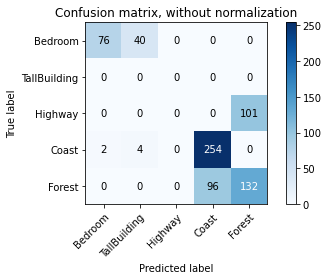

In [9]:

# FEATURE = 'tiny image'
FEATURE = 'bag of sift'
#FEATURE = 'placeholder'

CLASSIFIER = 'nearest neighbor'
#CLASSIFIER = 'support vector machine'
#CLASSIFIER = 'placeholder'

#data_path = '../../data/'
data_path = './data/'
#data_path = '/home/itu/Downloads/assignment3/Assignment_4_bag_of_words/4_bag_of_words/data/'
#data_path = '/Users/Infin/OpenCv/Bag Of Words/data/'

#This is the list of categories / directories to use. The categories are
#somewhat sorted by similarity so that the confusion matrix looks more
#structured (indoor and then urban and then rural).

categories = np.array(['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
              'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
              'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest'])
   
# #This list of shortened category names is used later for visualization.
# abbr_categories = np.array(['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
#                    'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For'])
    

#This function returns cell arrays containing the file path for each train
#and test image, as well as cell arrays with the label of each train and
#test image. By default all four of these arrays will be 1500x1 where each
#entry is a char array (or string).
print('Getting paths and labels for all train and test data\n')
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path, categories)


#   train_image_paths  1500x1   cell      
#   test_image_paths   705x1    cell           
#   train_labels       1500x1   cell         
#   test_labels        705x1    cell



## Step 1: Represent each image with the appropriate feature
# Each function to construct features should return an N x d matrix, where
# N is the number of paths passed to the function and d is the 
# dimensionality of each image representation. See the starter code for
# each function for more details.

print("Using",FEATURE, "representation for images\n")


if(FEATURE == 'bag of sift'):
    # Code build_vocabulary function 1st
    if(not os.path.exists('vocab.pkl')):
        print('No existing visual word vocabulary found. Computing one from training images\n')
        vocab_size = 99 #Larger values will work better (to a point) but be slower to compute
        vocab = build_vocabulary(train_image_paths, vocab_size)
        with open('vocab.pkl','wb') as f: pickle.dump(vocab, f)
    else:
        print("found vocabulary")
     # Code get_bags_of_sifts function
    train_image_feats = get_bags_of_sifts(train_image_paths)
    test_image_feats  = get_bags_of_sifts(test_image_paths)
        
elif(FEATURE == 'placeholder'):
    train_image_feats = []
    test_image_feats = []
        
else:
    print('Unknown feature type')




print('Using', CLASSIFIER, 'classifier to predict test set categories\n')

if(CLASSIFIER == 'nearest neighbor'):
    # Code nearest_neighbor_classify function above
    predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)
        
elif(CLASSIFIER == 'support vector machine'):
    # Code svm_classify function above
    predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)
        
elif(CLASSIFIER == 'placeholder'):
    # The placeholder classifier simply predicts a random category for every test case
    predicted_categories = np.random.permutation(test_labels)
        
else:
     print('Unknown classifier type')





display_results(test_labels, categories, predicted_categories)

# Interpreting your performance with 100 training examples per category:
#  accuracy  =   0 -> Your code is broken (probably not the classifier's
#                     fault! A classifier would have to be amazing to
#                     perform this badly).
#  accuracy ~= .07 -> Your performance is chance. Something is broken or
#                     you ran the starter code unchanged.
#  accuracy ~= .50 -> Rough performance with bag of SIFT and nearest
#                     neighbor classifier. Can reach .60 with K-NN and
#                     different distance metrics.
#  accuracy ~= .60 -> You've gotten things roughly correct with bag of
#                     SIFT and a linear SVM classifier.
#  accuracy >= .70 -> You've also tuned your parameters well. E.g. number
#                     of clusters, SVM regularization, number of patches
#                     sampled when building vocabulary, size and step for
#                     dense SIFT features.
#  accuracy >= .80 -> You've added in spatial information somehow or you've
#                     added additional, complementary image features. This
#                     represents state of the art in Lazebnik et al 2006.
#  accuracy >= .85 -> You've done extremely well. This is the state of the
#                     art in the 2010 SUN database paper from fusing many 
#                     features. Don't trust this number unless you actually
#                     measure many random splits.
#  accuracy >= .90 -> You used modern deep features trained on much larger
#                     image databases.
#  accuracy >= .96 -> You can beat a human at this task. This isn't a
#                     realistic number. Some accuracy calculation is broken
#                     or your classifier is cheating and seeing the test
#                     labels.
